## Automatic Report - Anonymized 

### Load the file

In [1]:
import pandas as pd
import numpy as np
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns

df= pd.read_xml(r'anon_file.xml')
df = df.iloc[7:, 5:]
df = df.drop(['MODEL_TYPE','REPORT_TYPE','REQUEST_ID','CREATION_DATE','REFERENCESTRING_1','LEDGER_ID','LEDGER_NAME','REFERENCENUMBER_2'], axis =1)
df.shape

(371, 15)

## Visualize the data

In [2]:
df['SUPPLIER_SITE_TYPE'] = df['SUPPLIER_SITE_TYPE'].str.replace(r'Supplier:', '', regex=True)

adjusted_rate = (df['TOTAL_COMPLETED'] / (df['TOTAL_CREATED'] - df['TOTAL_CANCELLED'])) * 100
adjusted_rate = np.nan_to_num(adjusted_rate, nan=0)

df['INVOICES VERIFIED_%'] = adjusted_rate

df.head(5)
#display(HTML(df.to_html()))

,P_REPORT_FORMAT,PERIOD,SUPPLIER_SITE_TYPE,TOTAL_CREATED,TOTAL_CANCELLED,TOTAL_COMPLETED,PURCHASE_ORDER,SUPPLIER_NAME,SUPPLIER_SITE,INVOICE_NUMBER,INVOICE_TYPE,INVOICE_CURRENCY,INVOICE_AMOUNT,INVOICE_DATE,MATCH_TYPE,INVOICES VERIFIED_%
7,None,SEP-22,GF - 3166721N,1.0,0.0,1.0,100.0,100.0,0.0,100.0,100.0,100.0,0.0,100.0,None,100.0
8,None,SEP-22,GF - 1553721N,2.0,0.0,2.0,100.0,100.0,100.0,100.0,100.0,100.0,50.0,100.0,None,100.0
9,None,SEP-22,GF - 7527270N,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0
10,None,SEP-22,SEDE LEGALE,2.0,0.0,2.0,50.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,None,100.0
11,None,SEP-22,SEDE LEGALEN,1.0,0.0,1.0,100.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,None,100.0


In [3]:
GDF =  df.groupby('PERIOD').agg(total_invoices =('TOTAL_CREATED','sum'))
print(GDF)

        total_invoices
PERIOD                
APR-23           256.0
DEC-22            84.0
FEB-23           116.0
JAN-23            68.0
JUN-23           216.0
MAR-23           328.0
MAY-23           504.0
NOV-22           124.0
OCT-22           212.0
SEP-22           234.0


In [4]:
GDF = df.groupby('PERIOD').agg(total_suppliers=('SUPPLIER_SITE_TYPE', 'nunique'))
print(GDF)

        total_suppliers
PERIOD                 
APR-23               29
DEC-22               11
FEB-23               18
JAN-23               13
JUN-23               23
MAR-23               39
MAY-23               30
NOV-22               16
OCT-22               20
SEP-22               33


In [5]:
for column in df:
    # Check if the column data type is float
    if df[column].dtype == float:
        # Convert the column to integer
        df[column] = df[column].astype(int)

In [6]:
averages2 = []

unique_supplier_types2 = df['SUPPLIER_SITE_TYPE'].unique()

for supplier_type in unique_supplier_types2:
    supplier_name_avg = df.loc[df['SUPPLIER_SITE_TYPE'] == supplier_type, 'SUPPLIER_NAME'].mean()
    verif_avg = df.loc[df['SUPPLIER_SITE_TYPE'] == supplier_type, 'INVOICES VERIFIED_%'].mean()
    num_avg = df.loc[df['SUPPLIER_SITE_TYPE'] == supplier_type, 'TOTAL_CREATED'].sum()
    cancelled_avg = df.loc[df['SUPPLIER_SITE_TYPE'] == supplier_type, 'TOTAL_CANCELLED'].sum()
    month = ', '.join(df.loc[df['SUPPLIER_SITE_TYPE'] == supplier_type, 'PERIOD'].astype(str))
    averages2.append((supplier_type, supplier_name_avg, verif_avg, num_avg, cancelled_avg, month))

averages2_df = pd.DataFrame(averages2, columns=['Supplier Type', 'Average Supplier Name', 'Average Invoices Verified', 'Average Total Created','Average Total Cancelled','Month'])

## List of suppliers with low recognition

In [7]:
bad_supplier = []

for supplier_type, supplier_name_avg, verif_avg,num_avg, cancelled_avg, month in averages2:
    if supplier_type not in ["Overall", None] and supplier_name_avg < 70 and verif_avg > 70 and num_avg > 10:
        bad_supplier.append((supplier_type, supplier_name_avg, verif_avg,num_avg, month))
    
bad_supplier_df = pd.DataFrame(bad_supplier, columns=['Supplier', 'Supplier Name Recognition','Invoices verified', 'Total invoices', 'Month'])
sorted_bad_supplier_df = bad_supplier_df.sort_values(by=['Total invoices'], ascending=False)

sorted_bad_supplier_df.head(20)
#display(HTML(sorted_bad_supplier_df.to_html()))

,Supplier,Supplier Name Recognition,Invoices verified,Total invoices,Month


In [8]:
len(bad_supplier_df)

0

## List of suppliers with good recognition

In [9]:
good_supplier = []

for supplier_type, supplier_name_avg, verif_avg,num_avg, cancelled_avg, month in averages2:
    if supplier_type not in [None, "Overall"] and supplier_name_avg > 70 and verif_avg > 70 and cancelled_avg < num_avg*0.20:
        good_supplier.append((supplier_type, supplier_name_avg, verif_avg,num_avg, cancelled_avg, month))
    
good_supplier_df = pd.DataFrame(good_supplier, columns=['Supplier', 'Supplier Name Recognition', 'Invoices verified', 'Total invoices', 'Total cancelled invoices', 'Month'])
sorted_good_supplier_df = good_supplier_df.sort_values(by=['Total invoices'], ascending=False)

sorted_good_supplier_df.head(20)
display(HTML(sorted_good_supplier_df.to_html()))

,Supplier,Supplier Name Recognition,Invoices verified,Total invoices,Total cancelled invoices,Month
2,SEDE LEGALE,94.753623,100.0,108,0,"SEP-22, SEP-22, SEP-22, SEP-22, SEP-22, SEP-22, SEP-22, SEP-22, SEP-22, OCT-22, OCT-22, OCT-22, OCT-22, OCT-22, OCT-22, OCT-22, NOV-22, NOV-22, NOV-22, NOV-22, NOV-22, DEC-22, DEC-22, DEC-22, DEC-22, DEC-22, DEC-22, DEC-22, DEC-22, JAN-23, JAN-23, JAN-23, JAN-23, JAN-23, FEB-23, FEB-23, FEB-23, FEB-23, FEB-23, MAR-23, MAR-23, MAR-23, MAR-23, MAR-23, MAR-23, MAR-23, MAR-23, MAR-23, MAR-23, MAR-23, APR-23, APR-23, APR-23, APR-23, APR-23, MAY-23, MAY-23, MAY-23, MAY-23, MAY-23, MAY-23, MAY-23, MAY-23, MAY-23, JUN-23, JUN-23, JUN-23, JUN-23, JUN-23"
3,SEDE LEGALEN,90.000000,100.0,77,0,"SEP-22, SEP-22, SEP-22, SEP-22, OCT-22, OCT-22, OCT-22, NOV-22, NOV-22, DEC-22, DEC-22, JAN-23, FEB-23, FEB-23, FEB-23, FEB-23, FEB-23, FEB-23, MAR-23, MAR-23, MAR-23, MAR-23, MAR-23, MAR-23, APR-23, APR-23, APR-23, APR-23, APR-23, APR-23, APR-23, MAY-23, MAY-23, MAY-23, MAY-23, MAY-23, MAY-23, MAY-23, MAY-23, MAY-23, MAY-23, JUN-23, JUN-23, JUN-23, JUN-23, JUN-23, JUN-23, JUN-23, JUN-23, JUN-23"
35,NVE,100.000000,100.0,21,0,"OCT-22, NOV-22, MAY-23"
13,SEDE LEGALE N,100.000000,100.0,19,0,"SEP-22, SEP-22, OCT-22, OCT-22, NOV-22, NOV-22, DEC-22, FEB-23, MAR-23, APR-23, APR-23, MAY-23, MAY-23, MAY-23, JUN-23"
15,GF - 1339742N,100.000000,100.0,16,0,"SEP-22, MAR-23, MAY-23"
75,GF - 2665601N,100.000000,100.0,15,0,"APR-23, MAY-23, JUN-23"
24,ADDRESS - 84272,100.000000,100.0,14,1,"SEP-22, OCT-22, NOV-22, DEC-22, JAN-23, MAR-23, JUN-23"
34,GF - 6849540N,100.000000,100.0,13,0,"OCT-22, NOV-22, MAR-23, JUN-23"
14,GF - 6448538N,90.000000,100.0,12,0,"SEP-22, DEC-22, JAN-23, MAR-23, MAY-23, JUN-23"
9,SEDE LEGALEE,100.000000,100.0,11,0,"SEP-22, SEP-22, OCT-22, NOV-22, JAN-23, MAY-23, MAY-23, JUN-23"


In [10]:
len(good_supplier_df)

95

## Unverified suppliers

In [11]:
unver_supplier = []

for supplier_type, supplier_name_avg, verif_avg,num_avg, cancelled_avg, month in averages2:
    if supplier_type not in [None, "Overall"] and verif_avg < 30 and cancelled_avg <= num_avg:
        unver_supplier.append((supplier_type, supplier_name_avg, verif_avg,num_avg, cancelled_avg))
    
unver_df = pd.DataFrame(unver_supplier, columns=['Supplier', 'Supplier Name Recognition', 'Invoices verified','Total invoices','Invoices cancelled'])
sorted_unver_df = unver_df.sort_values(by=['Total invoices'], ascending=False)

if sorted_unver_df.empty:
    print('No suppliers with unverified invoices!')

sorted_unver_df.head(20)
#display(HTML(sorted_unver_df.to_html()))

,Supplier,Supplier Name Recognition,Invoices verified,Total invoices,Invoices cancelled
0,GF - 7527270N,0.0,0.0,1,1
1,SITE - 3941079E,0.0,0.0,1,1


In [12]:
len(unver_df)

2

### Low invoice count suppliers 

In [13]:
lowcount_supplier = []

for supplier_type, supplier_name_avg, verif_avg,num_avg, cancelled_avg, month in averages2:
    if supplier_type not in [None, "Overall"] and num_avg < 5 and cancelled_avg <= num_avg and month and supplier_name_avg < 70 :
        lowcount_supplier.append((supplier_type, supplier_name_avg, verif_avg,num_avg, cancelled_avg, month))
    
lowcount_supplier_df = pd.DataFrame(lowcount_supplier, columns=['Supplier Type', 'Supplier Name Recognition', 'Invoices verified','Total invoices','Invoices cancelled', 'Month'])
sorted_lowcount_supplier_df = lowcount_supplier_df.sort_values(by=['Total invoices'], ascending=False)

if sorted_lowcount_supplier_df.empty:
    print('No suppliers that few invoices!')

sorted_lowcount_supplier_df.head(20)
#display(HTML(sorted_lowcount_supplier_df.to_html()))

,Supplier Type,Supplier Name Recognition,Invoices verified,Total invoices,Invoices cancelled,Month
1,GF - 389844N,33.333333,100.0,3,0,"SEP-22, OCT-22, FEB-23"
2,GF - 6624285N,50.000000,100.0,2,0,"SEP-22, MAR-23"
6,GF - 3785712N,0.000000,100.0,2,0,"FEB-23, MAY-23"
9,GF - 6852560N,0.000000,100.0,2,0,APR-23
0,GF - 7527270N,0.000000,0.0,1,1,SEP-22
3,SITE - 3941079E,0.000000,0.0,1,1,SEP-22
4,GF - 7505003N,0.000000,100.0,1,0,OCT-22
5,ParsePort ApS,0.000000,100.0,1,0,FEB-23
7,GF - 6868353N,0.000000,100.0,1,0,MAR-23
8,GF - 6913124N,0.000000,100.0,1,0,MAR-23


In [14]:
len(sorted_lowcount_supplier_df)

10

## Overall count:

In [15]:
total_sup_count = {(0,0):'Good supplier recognition rate:', (0,1): len(good_supplier_df),(1,0):'Bad supplier  recognition rate:', (1,1):len(bad_supplier_df), (2,0):'W/unverified recognition rate: ',(2,1):len(unver_df), (3,0):'Suppliers w/too few invoices: ',(3,1):len(sorted_lowcount_supplier_df)}

print("               TYPE ", "              COUNT ")
for i in range(4):
    for j in range(2):
        print(total_sup_count[(i, j)], end='     ')
 
    print()



               TYPE                COUNT 
Good supplier recognition rate:     95     
Bad supplier  recognition rate:     0     
W/unverified recognition rate:      2     
Suppliers w/too few invoices:      10     


## Overall rates of supplier recognition

In [16]:
m_rate = []

for date, match, rate, adj_rate in zip(df['PERIOD'], df['MATCH_TYPE'], df['SUPPLIER_NAME'], df['INVOICES VERIFIED_%']):
    if match is None:
        pass
    else:
        m_rate.append((date, match, rate, adj_rate))
            
m_rate_df = pd.DataFrame(m_rate, columns=['Month', 'Type', 'Supplier recognition Rate','Invoices verified'])
m_rate_df.groupby('Month', as_index=False)

display(HTML(m_rate_df.to_html()))

,Month,Type,Supplier recognition Rate,Invoices verified
0,SEP-22,Matched,98,100
1,SEP-22,Unmatched,75,100
2,SEP-22,Total,95,100
3,OCT-22,Matched,98,100
4,OCT-22,Unmatched,50,100
5,OCT-22,Total,94,100
6,NOV-22,Matched,100,100
7,NOV-22,Unmatched,50,100
8,NOV-22,Total,96,100
9,DEC-22,Matched,100,100


### Total rate vs. Verified

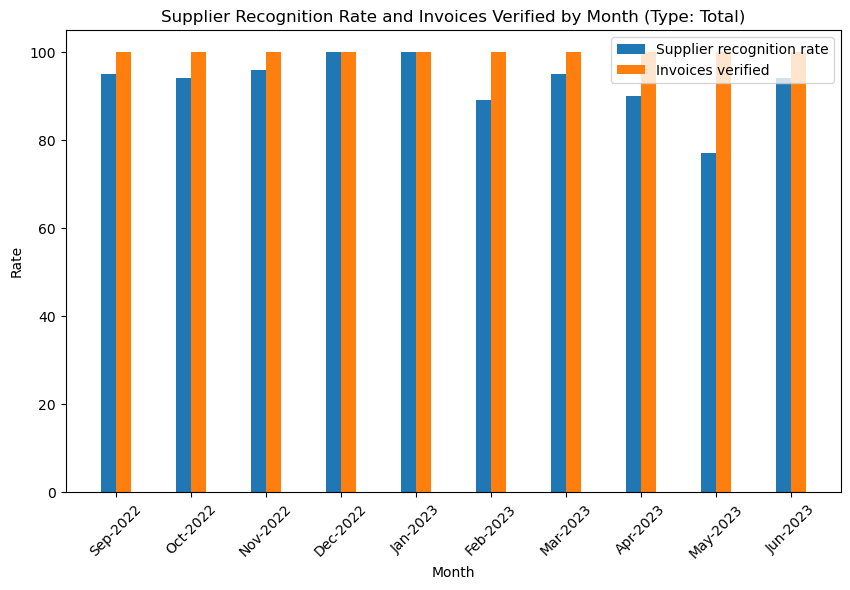

In [17]:
total_df = m_rate_df[m_rate_df['Type'] == 'Total'].copy()
total_df['Month'] = pd.to_datetime(total_df['Month'], format='%b-%y')
total_df.sort_values('Month', inplace=True)

bar_width = 0.2
x = np.arange(len(total_df['Month']))
plt.figure(figsize=(10, 6))
plt.bar(x, total_df['Supplier recognition Rate'], width=bar_width, label='Supplier recognition rate')
plt.bar(x + bar_width, total_df['Invoices verified'], width=bar_width, label='Invoices verified')
plt.xticks(x + bar_width/2, total_df['Month'].dt.strftime('%b-%Y'), rotation=45)
plt.xlabel('Month')
plt.ylabel('Rate')
plt.title('Supplier Recognition Rate and Invoices Verified by Month (Type: Total)')
plt.legend()
plt.show()

### Matched and Unmatched invoices

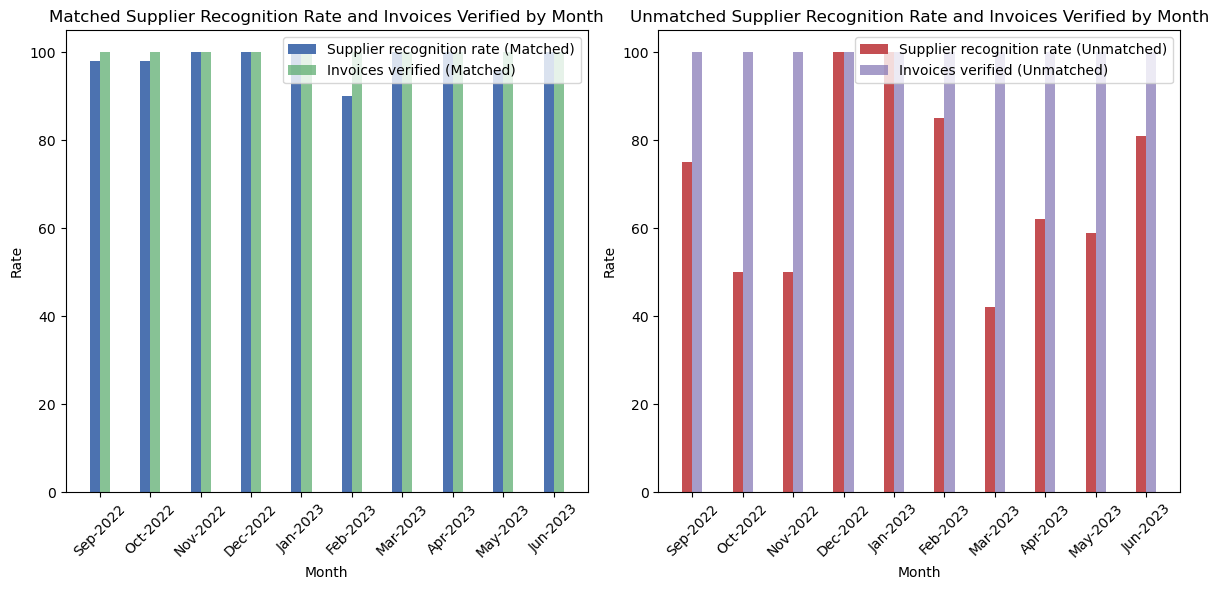

In [18]:
matched_df = m_rate_df[m_rate_df['Type'] == 'Matched'].copy()
matched_df['Month'] = pd.to_datetime(matched_df['Month'], format='%b-%y')
matched_df.sort_values('Month', inplace=True)
unmatched_df = m_rate_df[m_rate_df['Type'] == 'Unmatched'].copy()
unmatched_df['Month'] = pd.to_datetime(unmatched_df['Month'], format='%b-%y')
unmatched_df.sort_values('Month', inplace=True)

bar_width = 0.2

x = np.arange(len(matched_df['Month']))
matched_colors = ['#4C72B0', '#55A868']  # Blue and green
unmatched_colors = ['#C44E52', '#8172B2']  # Red and purple

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].bar(x, matched_df['Supplier recognition Rate'], width=bar_width, label='Supplier recognition rate (Matched)',
            color=matched_colors[0])
axes[0].bar(x + bar_width, matched_df['Invoices verified'], width=bar_width, label='Invoices verified (Matched)',
            color=matched_colors[1], alpha=0.7)
axes[1].bar(x, unmatched_df['Supplier recognition Rate'], width=bar_width, label='Supplier recognition rate (Unmatched)',
            color=unmatched_colors[0])
axes[1].bar(x + bar_width, unmatched_df['Invoices verified'], width=bar_width, label='Invoices verified (Unmatched)',
            color=unmatched_colors[1], alpha=0.7)
for ax in axes:
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(matched_df['Month'].dt.strftime('%b-%Y'), rotation=45)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Rate')
axes[0].set_title('Matched Supplier Recognition Rate and Invoices Verified by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Rate')
axes[1].set_title('Unmatched Supplier Recognition Rate and Invoices Verified by Month')
axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

### Line plot for total rates

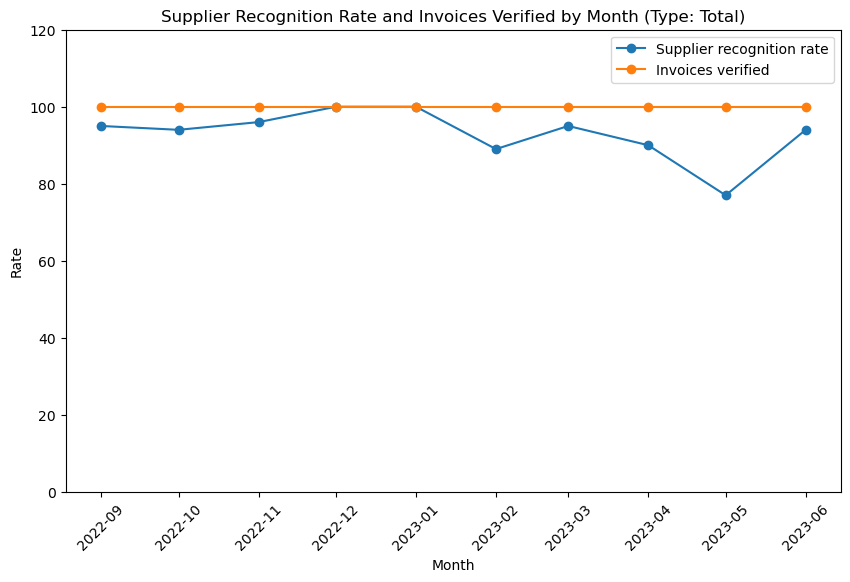

In [19]:
total_df = m_rate_df[m_rate_df['Type'] == 'Total'].copy()
total_df['Month'] = pd.to_datetime(total_df['Month'], format='%b-%y')
total_df.sort_values('Month', inplace=True)
plt.figure(figsize=(10, 6))
plt.plot(total_df['Month'], total_df['Supplier recognition Rate'], marker='o', label='Supplier recognition rate')
plt.plot(total_df['Month'], total_df['Invoices verified'], marker='o', label='Invoices verified')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Rate')
plt.title('Supplier Recognition Rate and Invoices Verified by Month (Type: Total)')
plt.ylim(0, 120)
plt.legend()
plt.show()

### Search for a particular supplier

In [ ]:
text = input("Enter search text (separated by commas): ")

if text:
    search_texts = [search.strip() for search in text.split(",")]
    matches = df['SUPPLIER_SITE_TYPE'].str.contains('|'.join(search_texts), case=False, na=False)

    if matches.any():
        matched_rows = df[matches]
        display(HTML(matched_rows.to_html()))
    else:
        print("No approximate matches found.")
else:
    print("Invalid search text.")                  